In [1]:
# Import necessary libraries and packages
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from typing import Type
import numpy as np
from torch.utils.data import Subset

In [2]:
# Global parameters
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
num_epochs = 10
batch_size = 64

# 1. Train the base model

In [3]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.maxpool(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)

        out = F.adaptive_avg_pool2d(out, (1, 1))
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])

In [4]:
# Load and normalize the SVHN dataset
transform_svhn = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset_svhn = torchvision.datasets.SVHN(root='./data', split='train', download=True, transform=transform_svhn)
trainloader_svhn = DataLoader(trainset_svhn, batch_size=batch_size, shuffle=True, num_workers=2)

testset_svhn = torchvision.datasets.SVHN(root='./data', split='test', download=True, transform=transform_svhn)
testloader_svhn = DataLoader(testset_svhn, batch_size=batch_size, shuffle=False, num_workers=2)



# Load and normalize the MNIST dataset
transform_mnist = transforms.Compose([
    transforms.Resize((32, 32)),  # Resize to be compatible with SVHN
    transforms.Grayscale(num_output_channels=3),  # Convert 1 channel grayscale to 3 channel grayscale
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

testset_mnist = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform_mnist)
testloader_mnist = DataLoader(testset_mnist, batch_size=batch_size, shuffle=False, num_workers=2)

100%|██████████| 182040794/182040794 [00:18<00:00, 10020933.69it/s]


100%|██████████| 64275384/64275384 [00:05<00:00, 12778277.42it/s]


100%|██████████| 9912422/9912422 [00:00<00:00, 109595501.97it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 47355626.98it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 22782692.64it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 7186167.02it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [7]:
def train(model, trainloader, criterion, optimizer, device, epochs):
    model.train()
    loss_values = []  # List to store loss values

    for epoch in range(epochs):
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Print the average loss of the entire epoch
        avg_loss = running_loss / len(trainloader)
        print(f'[{epoch + 1}] loss: {avg_loss:.3f}')
        loss_values.append(avg_loss)

    # Plot the training loss
    plt.figure(figsize=(10, 5))
    plt.plot(loss_values, label='Training Loss')
    plt.title('Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()



def evaluate(model, testloader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy

[1] loss: 0.723
[2] loss: 0.352
[3] loss: 0.270
[4] loss: 0.216
[5] loss: 0.174
[6] loss: 0.140
[7] loss: 0.112
[8] loss: 0.094
[9] loss: 0.075
[10] loss: 0.066


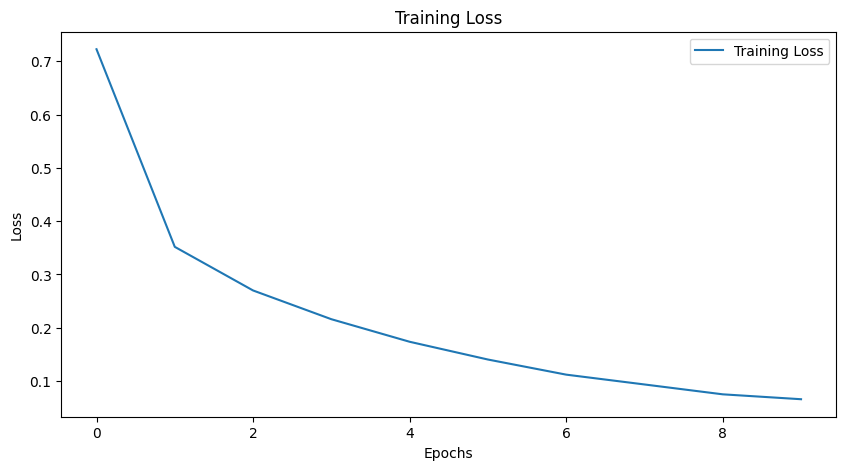

In [6]:
# Setup and repeat Train
net = ResNet18()
net = net.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4)

train(net, trainloader_svhn, criterion, optimizer, device, num_epochs)

In [7]:
# Test
svhn_accuracy = evaluate(net, testloader_svhn, device)
print(f'Accuracy of the network on the SVHN test images: {svhn_accuracy:.2f}%')

mnist_accuracy = evaluate(net, testloader_mnist, device)
print(f'Accuracy of the network on the MNIST test images: {mnist_accuracy:.2f}%')

Accuracy of the network on the SVHN test images: 90.31%
Accuracy of the network on the MNIST test images: 62.89%


# 2. Enhance the generalization

## 2.1 Model architecture modification

In [8]:
class BasicBlockNoBN(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlockNoBN, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=True)  # bias is True now
        # self.bn1 = nn.BatchNorm2d(planes)  # Removed batch normalization
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=True)  # bias is True now
        # self.bn2 = nn.BatchNorm2d(planes)  # Removed batch normalization

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=True)  # bias is True now
                # Batch normalization is removed from shortcut as well
            )

    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = self.conv2(out)
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNetNoBN(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNetNoBN, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=True)  # bias is True now
        # self.bn1 = nn.BatchNorm2d(64)  # Removed batch normalization
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.conv1(x))  # Removed the batch normalization
        out = self.maxpool(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)

        out = F.adaptive_avg_pool2d(out, (1, 1))
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def ResNet18NoBN():
    return ResNetNoBN(BasicBlockNoBN, [2, 2, 2, 2])

[1] loss: 2.245
[2] loss: 2.236
[3] loss: 2.235
[4] loss: 2.233
[5] loss: 2.225
[6] loss: 2.020
[7] loss: 1.412
[8] loss: 0.904
[9] loss: 0.700
[10] loss: 0.573


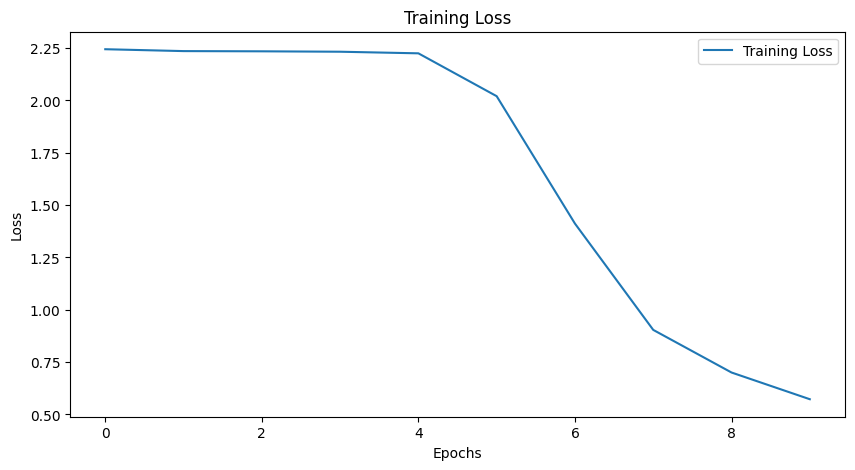

In [9]:
# Setup and repeat Train
net = ResNet18NoBN()
net = net.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4)

train(net, trainloader_svhn, criterion, optimizer, device, num_epochs)

In [10]:
# Test
svhn_accuracy = evaluate(net, testloader_svhn, device)
print(f'Accuracy of the network on the SVHN test images: {svhn_accuracy:.2f}%')

mnist_accuracy = evaluate(net, testloader_mnist, device)
print(f'Accuracy of the network on the MNIST test images: {mnist_accuracy:.2f}%')

Accuracy of the network on the SVHN test images: 84.00%
Accuracy of the network on the MNIST test images: 56.11%


## 2.2. Loss function

You can find different implementation of Label Smoothing in PyTorch in this link: https://stackoverflow.com/questions/55681502/label-smoothing-in-pytorch

In this code I test the accuracy of my implementation with built-in function of Pytorch.

In [5]:
class LabelSmoothingCrossEntropyLoss(nn.Module):
    def __init__(self, smoothing=0.1):
        super(LabelSmoothingCrossEntropyLoss, self).__init__()
        self.smoothing = smoothing

    def forward(self, input, target):
        log_probs = F.log_softmax(input, dim=-1)

        # Compute the smoothed labels
        num_classes = input.size(-1)
        with torch.no_grad():
            true_dist = torch.zeros_like(log_probs)
            true_dist.fill_(self.smoothing / (num_classes - 1))
            true_dist.scatter_(1, target.data.unsqueeze(1), 1.0 - self.smoothing)

        # Return the average loss
        return torch.mean(torch.sum(-true_dist * log_probs, dim=-1))

[1] loss: 1.465
[2] loss: 1.235
[3] loss: 1.185
[4] loss: 1.153
[5] loss: 1.130
[6] loss: 1.109
[7] loss: 1.094
[8] loss: 1.082
[9] loss: 1.070
[10] loss: 1.062


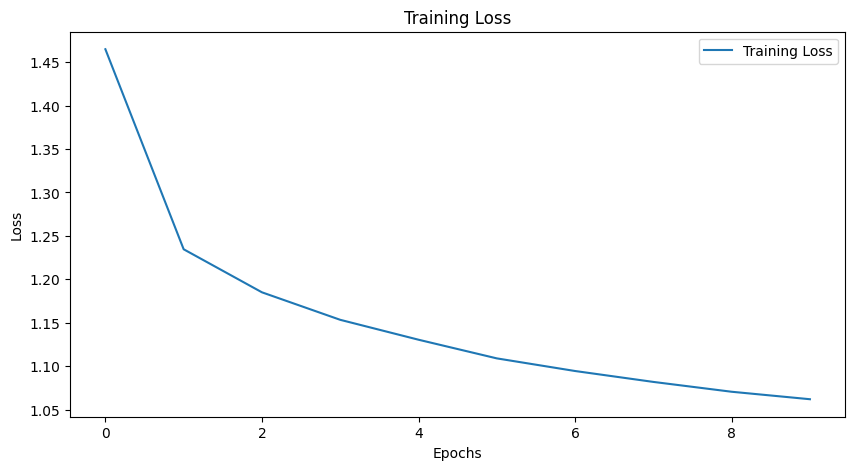

In [12]:
# Setup and repeat Train
net = ResNet18()
net = net.to(device)

# criterion = LabelSmoothingCrossEntropyLoss(smoothing=0.25)

criterion = torch.nn.CrossEntropyLoss(weight=None, size_average=None, 
                          ignore_index=- 100, reduce=None, 
                          reduction='mean', label_smoothing=0.25)

optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4)

train(net, trainloader_svhn, criterion, optimizer, device, num_epochs)

In [13]:
# Test
svhn_accuracy = evaluate(net, testloader_svhn, device)
print(f'Accuracy of the network on the SVHN test images: {svhn_accuracy:.2f}%')

mnist_accuracy = evaluate(net, testloader_mnist, device)
print(f'Accuracy of the network on the MNIST test images: {mnist_accuracy:.2f}%')

Accuracy of the network on the SVHN test images: 91.30%
Accuracy of the network on the MNIST test images: 63.53%


## 2.3 Data agumentaiton

In [14]:
# Define the augmentation pipeline
augmentation_transforms = transforms.Compose([
#     transforms.RandomRotation(degrees=10),  # Rotate +/- 10 degrees
#     transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # 10% translation
    transforms.RandomResizedCrop(size=(32, 32), scale=(0.8, 1.2)),  # Scaling between 80% and 120%
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # Randomly change brightness, contrast, and saturation
    transforms.RandomPerspective(distortion_scale=0.5),  # perspective transformations
    
    # Top gener: Color + Rotate + Size
    # Top acc: Perspective + Color + Size
    # Intersection: Color + Size
    # All
    
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Apply the augmentation pipeline only to the training data
trainloader_svhn = torch.utils.data.DataLoader(
    datasets.SVHN(root='./data', split='train', download=True, transform=augmentation_transforms),
    batch_size=batch_size, shuffle=True)

Using downloaded and verified file: ./data/train_32x32.mat


[1] loss: 1.326
[2] loss: 0.734
[3] loss: 0.602
[4] loss: 0.538
[5] loss: 0.497
[6] loss: 0.466
[7] loss: 0.441
[9] loss: 0.402
[10] loss: 0.387


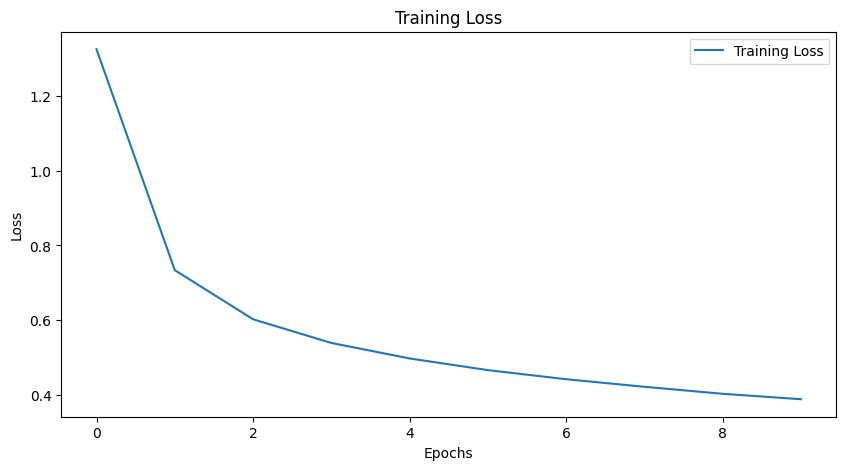

In [15]:
# Setup and repeat Train
net = ResNet18()
net = net.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4)

train(net, trainloader_svhn, criterion, optimizer, device, num_epochs)

In [16]:
# Test
svhn_accuracy = evaluate(net, testloader_svhn, device)
print(f'Accuracy of the network on the SVHN test images: {svhn_accuracy:.2f}%')

mnist_accuracy = evaluate(net, testloader_mnist, device)
print(f'Accuracy of the network on the MNIST test images: {mnist_accuracy:.2f}%')

Accuracy of the network on the SVHN test images: 93.83%
Accuracy of the network on the MNIST test images: 68.01%


## 2.4 Transfer learning

Need to run earlier dataloaders to remove the effect of recent data agumentation

[1] loss: 0.768
[2] loss: 0.341
[3] loss: 0.258
[4] loss: 0.209
[5] loss: 0.171
[6] loss: 0.140
[7] loss: 0.116
[8] loss: 0.098
[9] loss: 0.083
[10] loss: 0.069


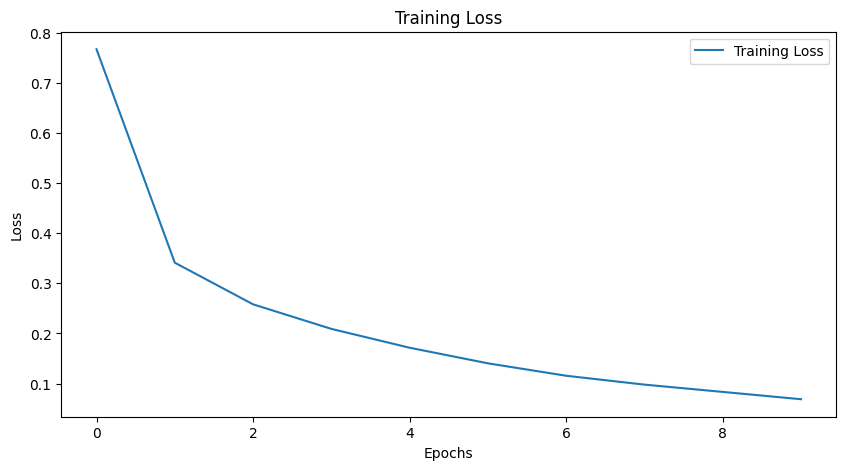

In [26]:
# Setup and repeat Train
net = models.resnet18(pretrained=True)
# Change class numbers to 10
net.fc = nn.Linear(net.fc.in_features, 10)
net = net.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4)

train(net, trainloader_svhn, criterion, optimizer, device, num_epochs)


In [27]:
# Test
svhn_accuracy = evaluate(net, testloader_svhn, device)
print(f'Accuracy of the network on the SVHN test images: {svhn_accuracy:.2f}%')

mnist_accuracy = evaluate(net, testloader_mnist, device)
print(f'Accuracy of the network on the MNIST test images: {mnist_accuracy:.2f}%')

Accuracy of the network on the SVHN test images: 92.09%
Accuracy of the network on the MNIST test images: 69.00%


## 2.5 Optimizer

[1] loss: 0.732
[2] loss: 0.394
[3] loss: 0.341
[4] loss: 0.312
[5] loss: 0.291
[6] loss: 0.272
[7] loss: 0.255
[8] loss: 0.244
[9] loss: 0.234
[10] loss: 0.227


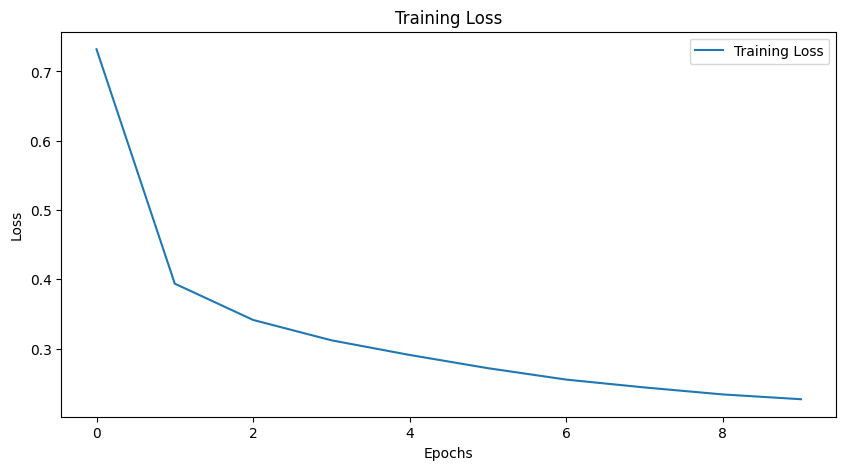

In [6]:
# Setup and repeat Train
net = ResNet18()
net = net.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=5e-4)

train(net, trainloader_svhn, criterion, optimizer, device, num_epochs)


In [7]:
# Test
svhn_accuracy = evaluate(net, testloader_svhn, device)
print(f'Accuracy of the network on the SVHN test images: {svhn_accuracy:.2f}%')

mnist_accuracy = evaluate(net, testloader_mnist, device)
print(f'Accuracy of the network on the MNIST test images: {mnist_accuracy:.2f}%')

Accuracy of the network on the SVHN test images: 91.74%
Accuracy of the network on the MNIST test images: 75.99%


# 3. Rverese training

## 3.1. Unsupervised
Choose the best setting from the previous step and retrain the model on MNIST instead of SVHN.

We need new data agumentation because the MNIST dataset contains grayscale images with a single channel, but the normalization was set up for three-channel (RGB) image.

In [17]:
mnist_augmentation_transforms = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.Grayscale(num_output_channels=3),
    
    transforms.RandomResizedCrop(size=(32, 32), scale=(0.8, 1.2)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomPerspective(distortion_scale=0.5),

    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [18]:
# Reload the MNIST dataset
trainset_mnist = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform_mnist)

# Apply the augmentation pipeline only to the training data
trainloader_mnist = torch.utils.data.DataLoader(
    datasets.MNIST(root='./data', train=True, download=True, transform=mnist_augmentation_transforms), batch_size=64, shuffle=True) # Agumentation from section 2.3

testset_mnist = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform_mnist)
testloader_mnist = DataLoader(testset_mnist, batch_size=batch_size, shuffle=False, num_workers=2)


# Reload the SVHN dataset
testset_svhn = torchvision.datasets.SVHN(root='./data', split='test', download=True, transform=transform_svhn)
testloader_svhn = DataLoader(testset_svhn, batch_size=batch_size, shuffle=False, num_workers=2)

Using downloaded and verified file: ./data/test_32x32.mat


[1] loss: 1.221
[2] loss: 1.178
[3] loss: 1.171
[4] loss: 1.165
[5] loss: 1.160
[6] loss: 1.158
[7] loss: 1.154
[8] loss: 1.153
[9] loss: 1.151
[10] loss: 1.149


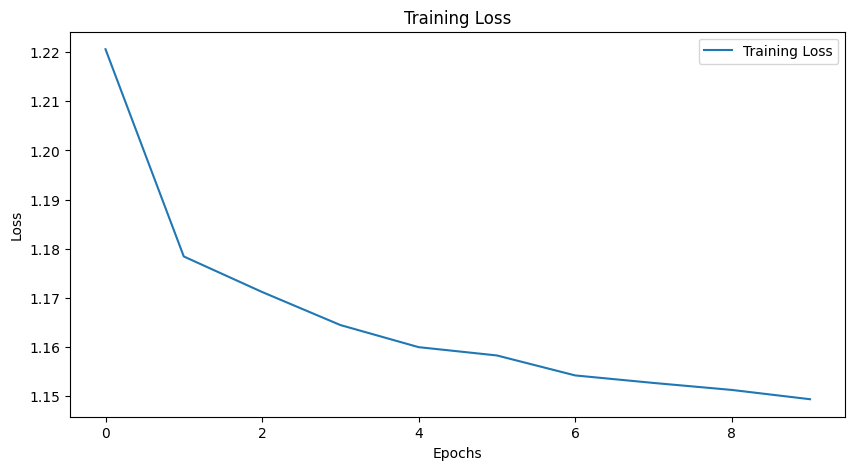

In [28]:
# Setup and repeat Train
net = models.resnet18(pretrained=True) #Pre-trained from section 2.4
net.fc = nn.Linear(net.fc.in_features, 10)
net = net.to(device)
criterion = LabelSmoothingCrossEntropyLoss(smoothing=0.25) # With label smoothing from section 2.2
optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=5e-4) # Adam from 2.5 section

train(net, trainloader_mnist, criterion, optimizer, device, num_epochs)

In [29]:
# Test
svhn_accuracy = evaluate(net, testloader_svhn, device)
print(f'Accuracy of the network on the SVHN test images: {svhn_accuracy:.2f}%')

mnist_accuracy = evaluate(net, testloader_mnist, device)
print(f'Accuracy of the network on the MNIST test images: {mnist_accuracy:.2f}%')

Accuracy of the network on the SVHN test images: 27.95%
Accuracy of the network on the MNIST test images: 99.01%


## 3.2. Supervised

### Fine-tune

In [30]:
# Freeze convolutional layers
for param in net.parameters():
    param.requires_grad = False

# Unfreeze the classifier layers
for param in net.fc.parameters():
    param.requires_grad = True

# Optimizer for the classifier
optimizer = optim.Adam(net.fc.parameters(), lr=0.001, weight_decay=5e-4)

[1] loss: 2.402
[2] loss: 2.358
[3] loss: 2.315
[4] loss: 2.259
[5] loss: 2.234
[6] loss: 2.203
[7] loss: 2.193
[8] loss: 2.160
[9] loss: 2.148
[10] loss: 2.127


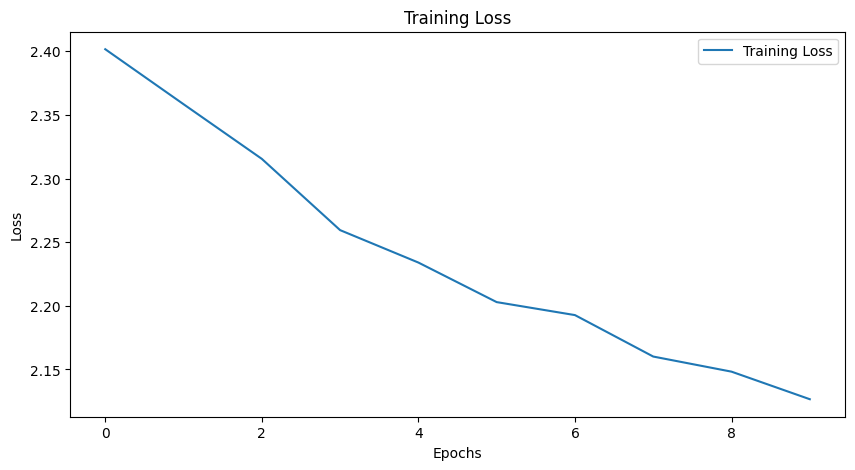

In [31]:
# After training on MNIST, fine-tune the classifier using a subset of SVHN test set
num_samples = 500
indices = np.random.choice(len(testset_svhn), num_samples, replace=False)
subset_svhn = Subset(testset_svhn, indices)

# Create a DataLoader for the SVHN subset
subset_loader_svhn = DataLoader(subset_svhn, batch_size=batch_size, shuffle=True, num_workers=2)

# Continue training (fine-tuning) on the SVHN subset
train(net, subset_loader_svhn, criterion, optimizer, device, num_epochs)

In [32]:
# Test
svhn_accuracy = evaluate(net, testloader_svhn, device)
print(f'Accuracy of the network on the SVHN test images: {svhn_accuracy:.2f}%')

mnist_accuracy = evaluate(net, testloader_mnist, device)
print(f'Accuracy of the network on the MNIST test images: {mnist_accuracy:.2f}%')

Accuracy of the network on the SVHN test images: 31.89%
Accuracy of the network on the MNIST test images: 77.33%
